In [1]:
# Import libraries
import random
import os
import numpy as np 
import pandas as pd 
import requests
from dotenv import load_dotenv

# Date
import datetime as dt
from datetime import date, timedelta, datetime

# EDA
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# FE
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.inspection import permutation_importance
# import eli5
# from eli5.sklearn import PermutationImportance
import shap

# Time Series - EDA and Modelling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Modeling and preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load environment variables from .env file
load_dotenv()

# Import environment variables
start_date = os.getenv('start_date')
end_date = os.getenv('end_date')
btc_etf_start_date = os.getenv('btc_etf_start_date')
btc_etf_end_date = os.getenv('btc_etf_end_date')

# Set main parameters
cryptocurrency = 'BTC'
target = 'ADJ_CLOSE'
forecasting_days = 10  

# 2) Load the data

In [3]:
df = pd.read_parquet('C:\\Users\\Stamatis\\Desktop\\MLCryptoPredictor\\MLCryptoPredictor\\data\\processed\\files\\final_df_without_stationarity_test.parquet.gzip')

## i) Data Preparation

In [4]:
# df.head(), df.info()

In [5]:
# Create a new dataframe with the potential target variable and the features
df_targets = df.iloc[:, -13:]
# Remove the last 13 columns from the original DataFrame
df = df.iloc[:, :-13]

### Stationarity

In [6]:
def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [7]:
# Stationarity check
check_stationarity(df['ADJ_CLOSE'])

df['ADJ_CLOSE_DIFF'] = df['ADJ_CLOSE'].diff()
df = df.dropna()

ADF Statistic: -0.595709
p-value: 0.871949
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


In [8]:
check_stationarity(df['ADJ_CLOSE_DIFF'])

ADF Statistic: -7.315061
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


### Seasonality

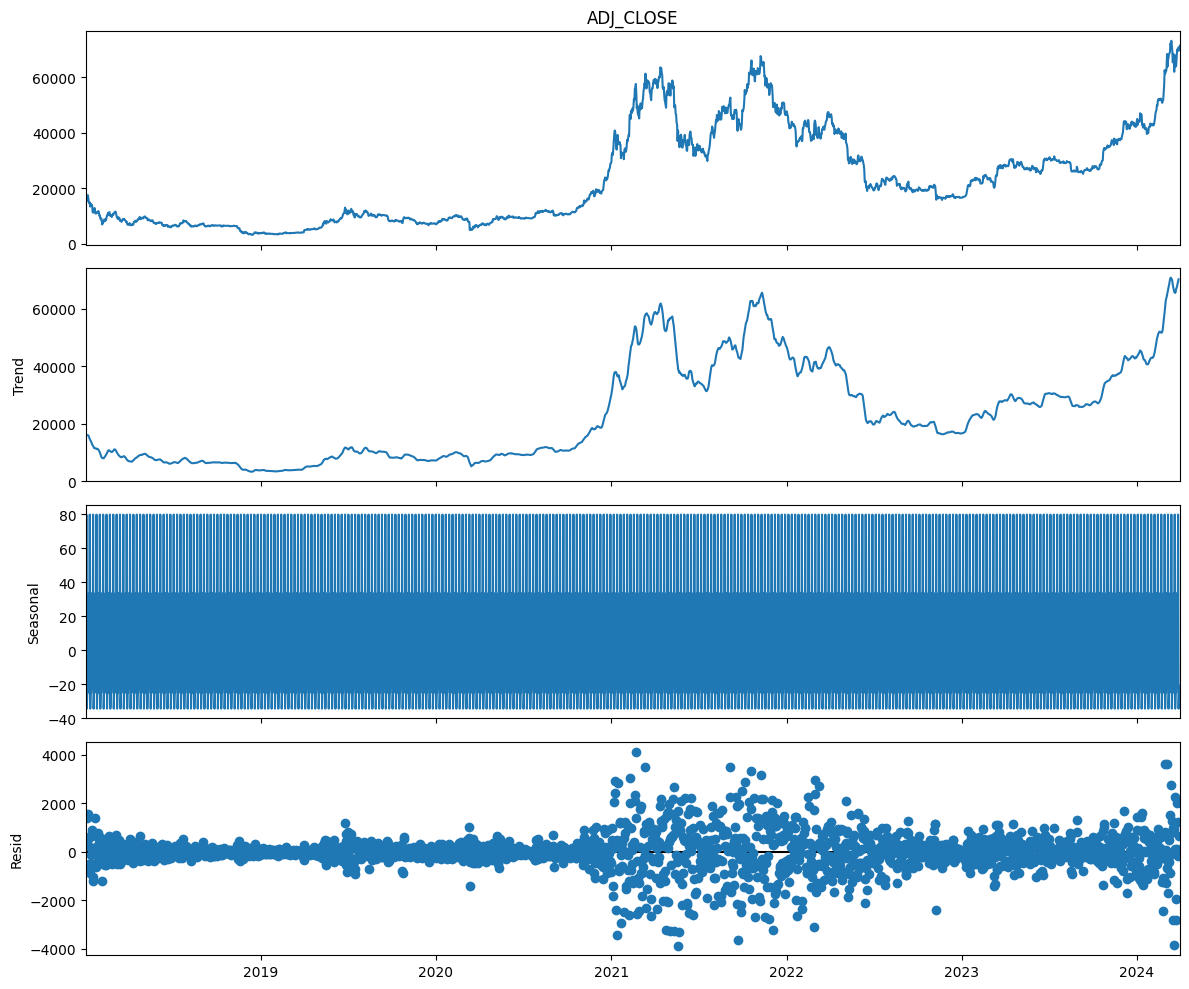

In [9]:
# Get seasonality of the time series
decomp = seasonal_decompose(df.ADJ_CLOSE)
fig = decomp.plot()
fig.set_size_inches((12, 10))
fig.tight_layout()
plt.show()

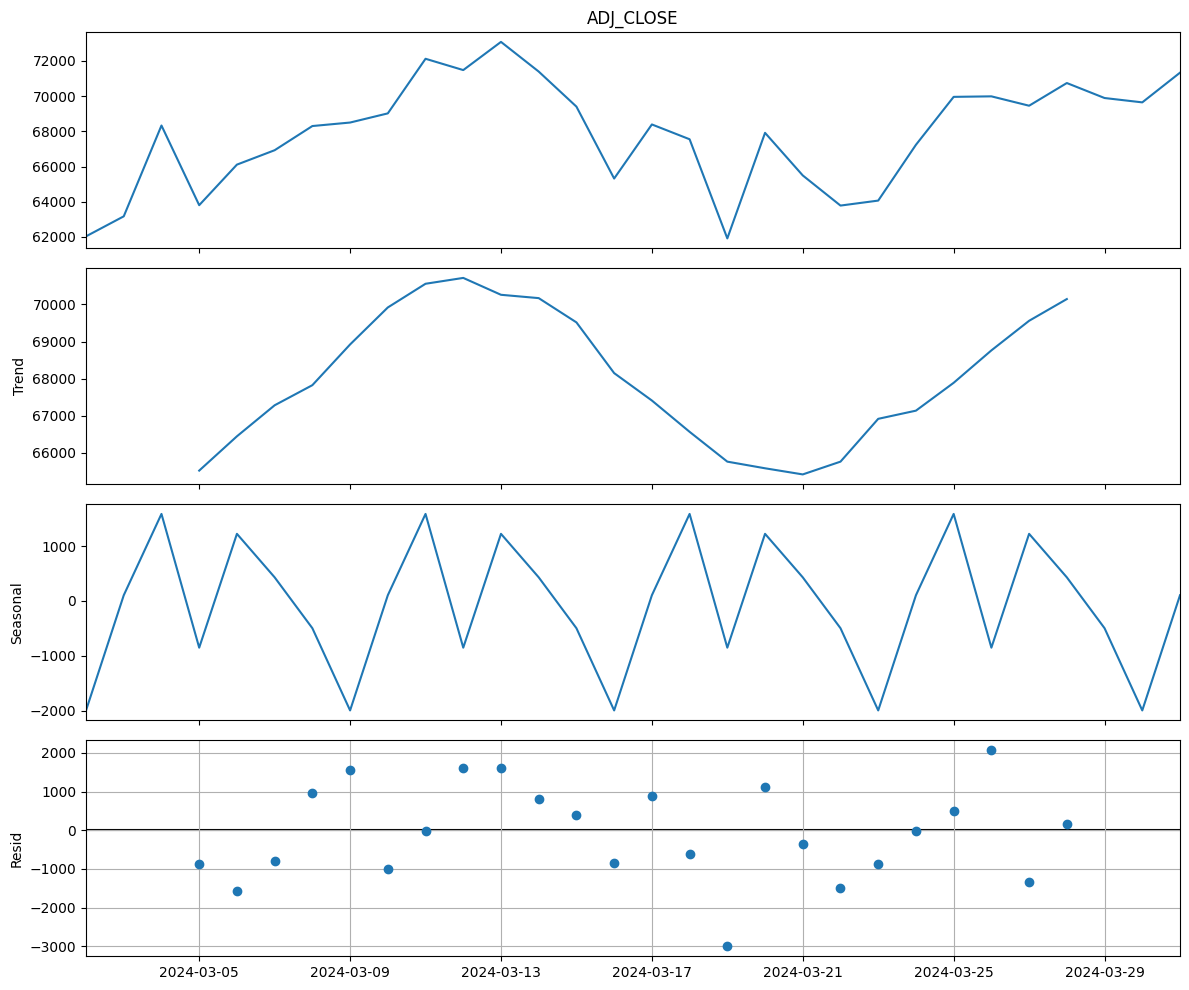

In [10]:
# Get seasonality of last months (Dec 2021) of the time series
decomposition = seasonal_decompose(df.tail(30).ADJ_CLOSE)
fig = decomposition.plot()
fig.set_size_inches((12, 10))
fig.tight_layout()
plt.grid(True)
plt.show()

### Feature Engineering

In [11]:
def get_tsfresh_features(data):
    # Get statistic features using library TSFRESH 
    # Thanks to https://www.kaggle.com/code/vbmokin/btc-growth-forecasting-with-advanced-fe-for-ohlc
    
    data = data.reset_index(drop=False).reset_index(drop=False)
    
    # Extract features
    extracted_features = extract_features(data, column_id="DATE", column_sort="DATE")
    
    # Drop features with NaN
    extracted_features_clean = extracted_features.dropna(axis=1, how='all').reset_index(drop=True)
    
    # Drop features with constants
    cols_std_zero  = []
    for col in extracted_features_clean.columns:
        if extracted_features_clean[col].std()==0:
            cols_std_zero.append(col)
    extracted_features_clean = extracted_features_clean.drop(columns = cols_std_zero)

    extracted_features_clean['DATE'] = data['DATE']   # For the merging
    
    return extracted_features_clean

def get_add_features(df_feat):
    # FE for data as row of DataFrame
    # Thanks to https://www.kaggle.com/code/vbmokin/g-research-crypto-forecasting-baseline-fe
    
    # Two new features from the competition tutorial
    df_feat['UPPER_SHADOW'] = df_feat['HIGH'] - np.maximum(df_feat['ADJ_CLOSE'], df_feat['OPEN'])
    df_feat['LOWER_SHADOW'] = np.minimum(df_feat['ADJ_CLOSE'], df_feat['OPEN']) - df_feat['LOW']
    
    # Thanks to https://www.kaggle.com/code1110/gresearch-simple-lgb-starter
    df_feat['HIGH_TO_LOW'] = (df_feat['HIGH'] / df_feat['LOW']).replace([np.inf, -np.inf, np.nan], 0.)
    
    return df_feat

In [12]:
%%time
# FE with TSFRESH
extracted_features_clean = get_tsfresh_features(df[['ADJ_CLOSE']])

# Get all features
df = pd.merge(df, extracted_features_clean, how='left', on='DATE')

df = get_add_features(df)

Feature Extraction: 100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


CPU times: total: 4.52 s
Wall time: 52.2 s


### Train-Test-Validation split

In [13]:
df.head()

,DATE,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,GOLD_ADJ_CLOSE,SILVER_ADJ_CLOSE,OIL_ADJ_CLOSE,...,ADJ_CLOSE__quantile__q_0.9,"ADJ_CLOSE__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","ADJ_CLOSE__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","ADJ_CLOSE__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","ADJ_CLOSE__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","ADJ_CLOSE__fft_coefficient__attr_""real""__coeff_0","ADJ_CLOSE__fft_coefficient__attr_""abs""__coeff_0",UPPER_SHADOW,LOWER_SHADOW,HIGH_TO_LOW
0,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,1313.699951,17.121000,60.369999,...,14982.099609,9188.393427,5811.250254,4109.174461,2905.625127,14982.099609,14982.099609,462.500000,461.400391,1.173281
1,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,1316.199951,17.184999,61.630001,...,15201.000000,9322.643163,5896.157241,4169.212768,2948.078621,15201.000000,15201.000000,371.799805,133.700195,1.049062
2,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,1319.400024,17.188999,62.009998,...,15599.200195,9566.855934,6050.610959,4278.428040,3025.305480,15599.200195,15599.200195,140.500000,748.500000,1.083837
3,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,1320.300049,17.205000,61.439999,...,17429.500000,10689.363134,6760.546848,4780.428521,3380.273424,17429.500000,17429.500000,275.699219,274.400391,1.164601
4,2018-01-06,17462.099609,17712.400391,16764.599609,17527.000000,17527.000000,18314600448,1318.599976,17.063999,61.730000,...,17527.000000,10749.159050,6798.365106,4807.170067,3399.182553,17527.000000,17527.000000,185.400391,697.500000,1.056536


In [17]:
def cut_data(df, y, num_start, num_end):
    # Cutting dataframe df and array or list for [num_start, num_end-1]        
    df2 = df[num_start:(num_end+1)]
    y2 = y[num_start:(num_end+1)] if y is not None else None
    return df2, y2

def get_train_valid_test_mf(df, forecasting_days, target='target'):
    # Get training, validation and test datasets with target for multi-features ML models    
    
    df = df.drop(columns = ['DATE']).dropna(how="any").reset_index(drop=True)
    # Save and drop target        
    y = df.pop(target)

    
    # Get starting points for the recovering "ADJ_CLOSE" from "Close_diff_shigted"
    N = len(df)
    start_points = {'valid_start_point' : df.loc[N-forecasting_days-1, 'CLOSE'],
                    'test_start_point' : df.loc[N-1, 'CLOSE']}

    # Standartization data
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
    
    
    train, ytrain = cut_data(df.copy(), y, 0, N-2*forecasting_days-1)
    valid, yvalid = cut_data(df.copy(), y, N-2*forecasting_days, N-forecasting_days-1)
    test, ytest = cut_data(df.copy(), y, N-forecasting_days, N)


    # Train+valid - for optimal model training
    train_valid = pd.concat([train, valid])
    y_train_valid = pd.concat([ytrain, yvalid])

    print(f'Origin dataset has {len(df)} rows and {len(df.columns)} features')
    print(f'Get training dataset with {len(train)} rows')
    print(f'Get validation dataset with {len(valid)} rows')
    print(f'Get test dataset with {len(test)} rows')
    
    return train, ytrain, valid, yvalid, test, ytest, train_valid, y_train_valid, start_points

def calc_metrics(type_score, list_true, list_pred):
    # Calculation score with type=type_score for list_true and list_pred 
    if type_score=='r2_score':
        score = r2_score(list_true, list_pred)
    elif type_score=='rmse':
        score = mean_squared_error(list_true, list_pred, squared=False)
    elif type_score=='mape':
        score = mean_absolute_percentage_error(list_true, list_pred)
    return score

def result_add_metrics(result, n, y_true, y_pred):
    # Calculation and addition metrics into dataframe result[n,:]
    
    result.loc[n,'r2_score'] = calc_metrics('r2_score', y_true, y_pred)
    result.loc[n,'rmse'] = calc_metrics('rmse', y_true, y_pred)      # in coins
    result.loc[n,'mape'] = 100*calc_metrics('mape', y_true, y_pred)  # in %
    
    return result

In [15]:
# Results of all models
result = pd.DataFrame(columns = ['name_model', 'type_data', 'r2_score', 'rmse', 'mape', 'params', 'ypred'])

### FBProphet

In [19]:
train_mf, ytrain_mf, valid_mf, yvalid_mf, test_mf, ytest_mf, train_valid_mf, y_train_valid_mf, starting_point = get_train_valid_test_mf(df.copy(), forecasting_days, target= target)

Origin dataset has 2280 rows and 349 features
Get training dataset with 2260 rows
Get validation dataset with 10 rows
Get test dataset with 10 rows


In [ ]:
def prophet_modeling(result, 
                     cryptocurrency, 
                     train, 
                     test, 
                     holidays_df, 
                     period_days,
                     fourier_order_seasonality,
                     forecasting_period,
                     name_model,
                     type_data):
    # Performs FB Prophet model training for given train dataset, holidays_df and seasonality_mode
    # Performs forecasting with period by this model, visualization and error estimation
    # df - dataframe with real data in the forecasting_period
    # can be such combinations of parameters: train=train, test=valid or train=train_valid, test=test
    # Save results into dataframe result
    
    # Build Prophet model with parameters and structure 
    model = Prophet(daily_seasonality=False, 
                    weekly_seasonality=False, 
                    yearly_seasonality=False, 
                    changepoint_range=1, 
                    changepoint_prior_scale = 0.5, 
                    holidays=holidays_df, 
                    seasonality_mode = 'multiplicative'
                   )
    model.add_seasonality(name='seasonality', period=period_days, 
                          fourier_order=fourier_order_seasonality, 
                          mode = 'multiplicative', prior_scale = 0.5)
    # Training model for df
    model.fit(train)
    
    # Make a forecast
    future = model.make_future_dataframe(periods = forecasting_period)
    forecast = model.predict(future)
    
    # Draw plot of the values with forecasting data
    figure = model.plot(forecast, xlabel = 'Date', ylabel = f"{name_model} for {cryptocurrency}")
    
    # Draw plot with the components (trend and seasonalities) of the forecasts
    figure_component = model.plot_components(forecast)
    
    # Ouput the prediction for the next time on forecasted_days
    #forecast[['yhat_lower', 'yhat', 'yhat_upper']] = forecast[['yhat_lower', 'yhat', 'yhat_upper']].round(1)
    #forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].tail(forecasting_period)
    
    # Forecasting data by the model
    ypred = forecast['yhat'][-forecasting_period:]
    #print(ypred)
    # Save results
    n = len(result)
    result.loc[n,'name_model'] = f"Prophet_{name_model}"
    result.loc[n,'type_data'] = type_data
    result.at[n,'params'] = [period_days]+[fourier_order_seasonality]
    result.at[n,'ypred'] = ypred
    #result = result_add_metrics(result, n, test['y'], y_pred)
    
    return result, ypred

In [ ]:
%%time
# Models tuning
if is_Prophet:
    for period_days in [4, 5, 7, 14]:
        for fourier_order_seasonality in [3, 12]:
            result, _ = prophet_modeling(result, 
                                         cryptocurrency, 
                                         train_ts, 
                                         valid_ts, 
                                         holidays_df, 
                                         period_days,
                                         fourier_order_seasonality,
                                         forecasting_days,
                                         f'{period_days}_days_{fourier_order_seasonality}_order',
                                         'valid')

# Nixtla Library - https://nixtlaverse.nixtla.io/

## Transform data into Nixtla formulation - Long Format

In [8]:
df_final = df.copy()
df_final = df_final.reset_index()
df_final = df_final.melt(id_vars = 'DATE')

In [9]:
df_final

,DATE,variable,value
0,2018-01-01,OPEN,-504.253940
1,2018-01-02,OPEN,1336.146451
2,2018-01-03,OPEN,275.446256
3,2018-01-04,OPEN,189.446256
4,2018-01-05,OPEN,1967.845670
...,...,...,...
695700,2024-03-26,BTC_DAILY_RETURNS_PERC,-0.216134
695701,2024-03-27,BTC_DAILY_RETURNS_PERC,-1.018556
695702,2024-03-28,BTC_DAILY_RETURNS_PERC,1.598924
695703,2024-03-29,BTC_DAILY_RETURNS_PERC,-1.462426


In [ ]:

prices = prices.rename(columns={'DATE': 'ds', 'variable': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices